## Important 
you need to run the notebook within xvfb (x virtual frame buffer)
`xvfb-run -s "-screen 0 1400x900x24" jupyter notebook`

also make sure you run tensorboard:
`tensorboard --logdir /tmp/tensorboard/`

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from IPython.display import IFrame
from include_pycharm_modules import import_source_folders
import_source_folders("/home/kic/sources/private/projects/pandas-quant")

adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-common
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-quant
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-utils
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-1ntegration-test
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-quant-data-provider
adding module /home/kic/sources/private/projects/pandas-quant/pandas-ml-quant-rl


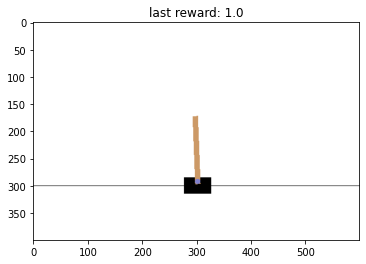

((array([ 0.01893877, -0.24166175, -0.03877306,  0.31488371]),
  array([], dtype=float64)),
 1.0,
 False,
 {})

In [2]:
from pandas_ml_quant_rl.model.environments import CartPoleWrappedEnv
import numpy as np

env = CartPoleWrappedEnv(auto_render_after_steps=100)

s = env.reset()
env.render()
env.step(np.random.choice(env.action_space.n))

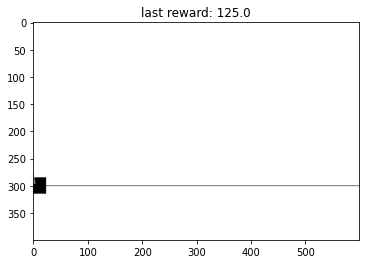

Solved 100.14975509236561 in 70 episodes


In [3]:
import torch as T
import torch.nn as nn
from torch.optim import RMSprop
from pandas_ml_quant_rl.model.agent import PolicyNetwork
from pandas_ml_quant_rl.model.agent import DQNAgent

class DQNet(PolicyNetwork):
    
    def __init__(self, input_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, n_actions),
        )

    def get_value_for(self, states, action):
        return self._estimate_action(*states) \
                   .gather(dim=1, index=T.LongTensor(action).to(self.device).unsqueeze(-1))

    def get_state_value(self, states):
        values = self._estimate_action(*states).detach()
        return values.max(dim=1)

        
    def _estimate_action(self, state, state_2):
        return self.net(state)



agent2 = DQNAgent(
    lambda: DQNet(env.observation_space.shape[0], 2).cpu(),
    exit_criteria=lambda reward, cnt: reward > 100 or cnt > 500,
    optimizer=lambda p: RMSprop(p),
    batch_size=128,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay = 150
)

agent2.fit(env)

In [4]:
IFrame('http://localhost:6006/', width='100%', height='800px')

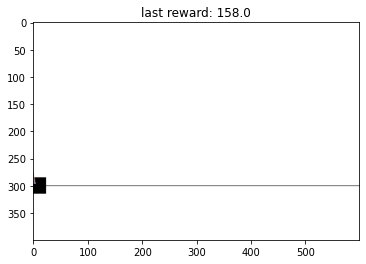

In [5]:
rewards = agent2.play_episode(env)

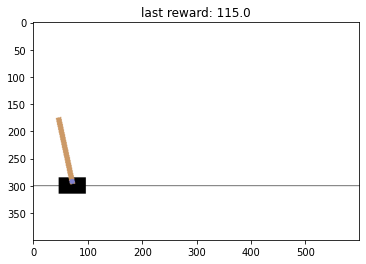

Solved 100.12749771365021 in 91 episodes


In [6]:
# Now with a Dueling Network !! 

import torch.nn as nn
from torch.optim import RMSprop
from pandas_ml_quant_rl.model.agent import PolicyNetwork
from pandas_ml_quant_rl.model.agent import DQNAgent

class DuelingDQNet(PolicyNetwork):
    
    def __init__(self, input_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
        )
        
        self.fc_adv = nn.Sequential( 
            nn.Linear(8, 4), 
            nn.ReLU(), 
            nn.Linear(4, n_actions) 
        ) 
        self.fc_val = nn.Sequential( 
            nn.Linear(8, 4), 
            nn.ReLU(), 
            nn.Linear(4, 1) 
        )

    def get_value_for(self, states, action):
        return self._estimate_action(*states) \
                   .gather(dim=1, index=T.LongTensor(action).to(self.device).unsqueeze(-1))

    def get_state_value(self, states):
        values = self._estimate_action(*states).detach()
        return values.max(dim=1)

        
    def _estimate_action(self, state, state_2):
        x = self.net(state)
        val = self.fc_val(x) 
        adv = self.fc_adv(x) 
        return val + adv - adv.mean()



agent3 = DQNAgent(
    lambda: DuelingDQNet(env.observation_space.shape[0], 2).cpu(),
    exit_criteria=lambda reward, cnt: reward > 100 or cnt > 500,
    optimizer=lambda p: RMSprop(p),
    batch_size=128,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay = 150
)

agent3.fit(env)

In [7]:
IFrame('http://localhost:6006/', width='100%', height='800px')

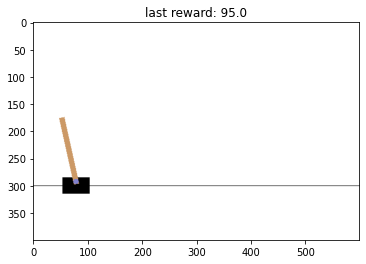

In [8]:
rewards = agent3.play_episode(env)

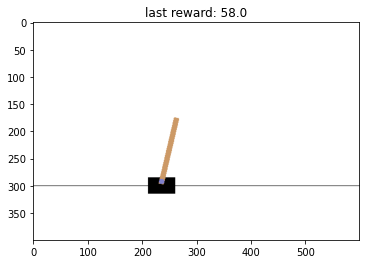

Solved 27.651655458380546 in 501 episodes


In [9]:
# Now with a Probabilistic Network (QR_DQN) !! 

import torch.nn as nn
from torch.optim import RMSprop
from pandas_ml_quant_rl.model.agent import PolicyNetwork
from pandas_ml_quant_rl.model.agent import DQNAgent
from pandas_ml_quant_rl.model.agent.pytorch.losses import QuantileHuberLoss

class QR_DQN(PolicyNetwork):
    def __init__(self, input_size, n_actions, n_qunatiles=32):
        super().__init__()
        self.n_actions = n_actions
        self.n_qunatiles = n_qunatiles
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, n_actions * n_qunatiles)
        )
        

    def get_value_for(self, states, action):
        probs = self._estimate_action(*states)
        index = T.LongTensor(action).unsqueeze(-1).unsqueeze(-1).expand(probs.shape[0], self.n_qunatiles, 1)
        return probs.gather(dim=2, index=index)

    def get_state_value(self, states):
        probs = self._estimate_action(*states)
        
        return (
            probs \
                .gather(dim=2, index=T.argmax(probs.mean(dim=1), dim=1, keepdim=True).unsqueeze(-1).expand(probs.shape[0], self.n_qunatiles, 1)) \
                .transpose(1, 2),
            T.argmax(probs.mean(dim=1), dim=1)
        )

    def _estimate_action(self, state, state_2):
        x = self.net(state)
        return x.view(state.shape[0], self.n_qunatiles, self.n_actions)
    


agent5 = DQNAgent(
    lambda: QR_DQN(env.observation_space.shape[0], 2).cpu(),
    exit_criteria=lambda reward, cnt: reward > 100 or cnt > 500,
    optimizer=lambda p: RMSprop(p),
    objective=QuantileHuberLoss(),
    batch_size=32,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay = 200,
    nr_episodes_update_target=0.01
)

agent5.fit(env)

In [10]:
IFrame('http://localhost:6006/', width='100%', height='800px')